# Desarrollo M2

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import pandas as pd

import seaborn as sns
sns.set_context(context="notebook")
sns.set_style("ticks")

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from src.data.dataset import lc_dataset
from src.models.model import periodicTransformer, MetricTracker
from src.models.layer import TimeFilm
from src.visualization.plots import plot_periodic
from src.data.curve_generator import random_periodic_sin_mix
from src.utils import get_project_root
from src.data.light_curve import LightCurve


/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Objetivos

- [ ] Cambiar el codificador posicional actual (discreto) a uno continuo, puede ser el de T. Sousa o O. Pimentel
- [X] Probar con un conjunto más amplio de clases (curvas sinteticas), por lo que vi tienen dos clases por ahora, traten de extender el problema a almenos 4
- [ ] Realizar pruebas con curvas dobladas (en fase), curvas no dobladas y otras con fase aumentada (esto es simplemente entregar dos fases o tres, una tras la otra)
- [ ] Observar como se comportan los pesos de atención en el caso de series periodicas vs no periodicas, para esto recomiendo que dentro de las 4 clases periodicas que vayan a generar integren una quinta que sea no periodica, sería interesante ver como clasifica esta serie no periodica si el modelo fue entrenado con solo curvas periodicas
- [X] Esto es un poco más libre, pero generar algunas figuras como matrices de confusión, curvas roc, curvas de perdida o accuracy en el tiempo, visualización de el espacio de caracteristicas etc..

## Clasificación de 5 clases

### Generación de datos

#### Datos sintéticos

In [2]:
train_data = lc_dataset()
train_data.add_curves('sinmix', N=400, seq_len=60, min_period=0.5, max_period=2, label=0)
train_data.add_curves('sinmix', N=400, seq_len=60, min_period=5, max_period=10, label=1)
# train_data.add_curves('sinmix', N=300, seq_len=200, min_period=5, max_period=10, label=1)
train_data.add_curves('sawtooth', N=400, seq_len=60, min_period=1.5, max_period=4, label=2)
train_data.add_curves('square', N=400, seq_len=60, min_period=2, max_period=8, label=3)
train_data.add_curves('gauss', N=400, seq_len=60, min_period=2, max_period=8, label=4)

val_data = lc_dataset(seed=127)
val_data.add_curves('sinmix', N=100, seq_len=60, min_period=0.5, max_period=2, label=0)
val_data.add_curves('sinmix', N=100, seq_len=60, min_period=5, max_period=10, label=1)
val_data.add_curves('sawtooth', N=100, seq_len=60, min_period=1.5, max_period=4, label=2)
val_data.add_curves('square', N=100, seq_len=60, min_period=2, max_period=8, label=3)
val_data.add_curves('gauss', N=100, seq_len=60, min_period=2, max_period=8, label=4)

#### Datos reales

In [2]:
dataset = lc_dataset()
dataset.add_dataset('macho', N=4000)

In [3]:
train_data, val_test_data = dataset.train_test_split(test_size=0.4)
val_data, test_data = val_test_data.train_test_split(test_size=0.5)

### Visualización del dataset

IndexError: single positional indexer is out-of-bounds

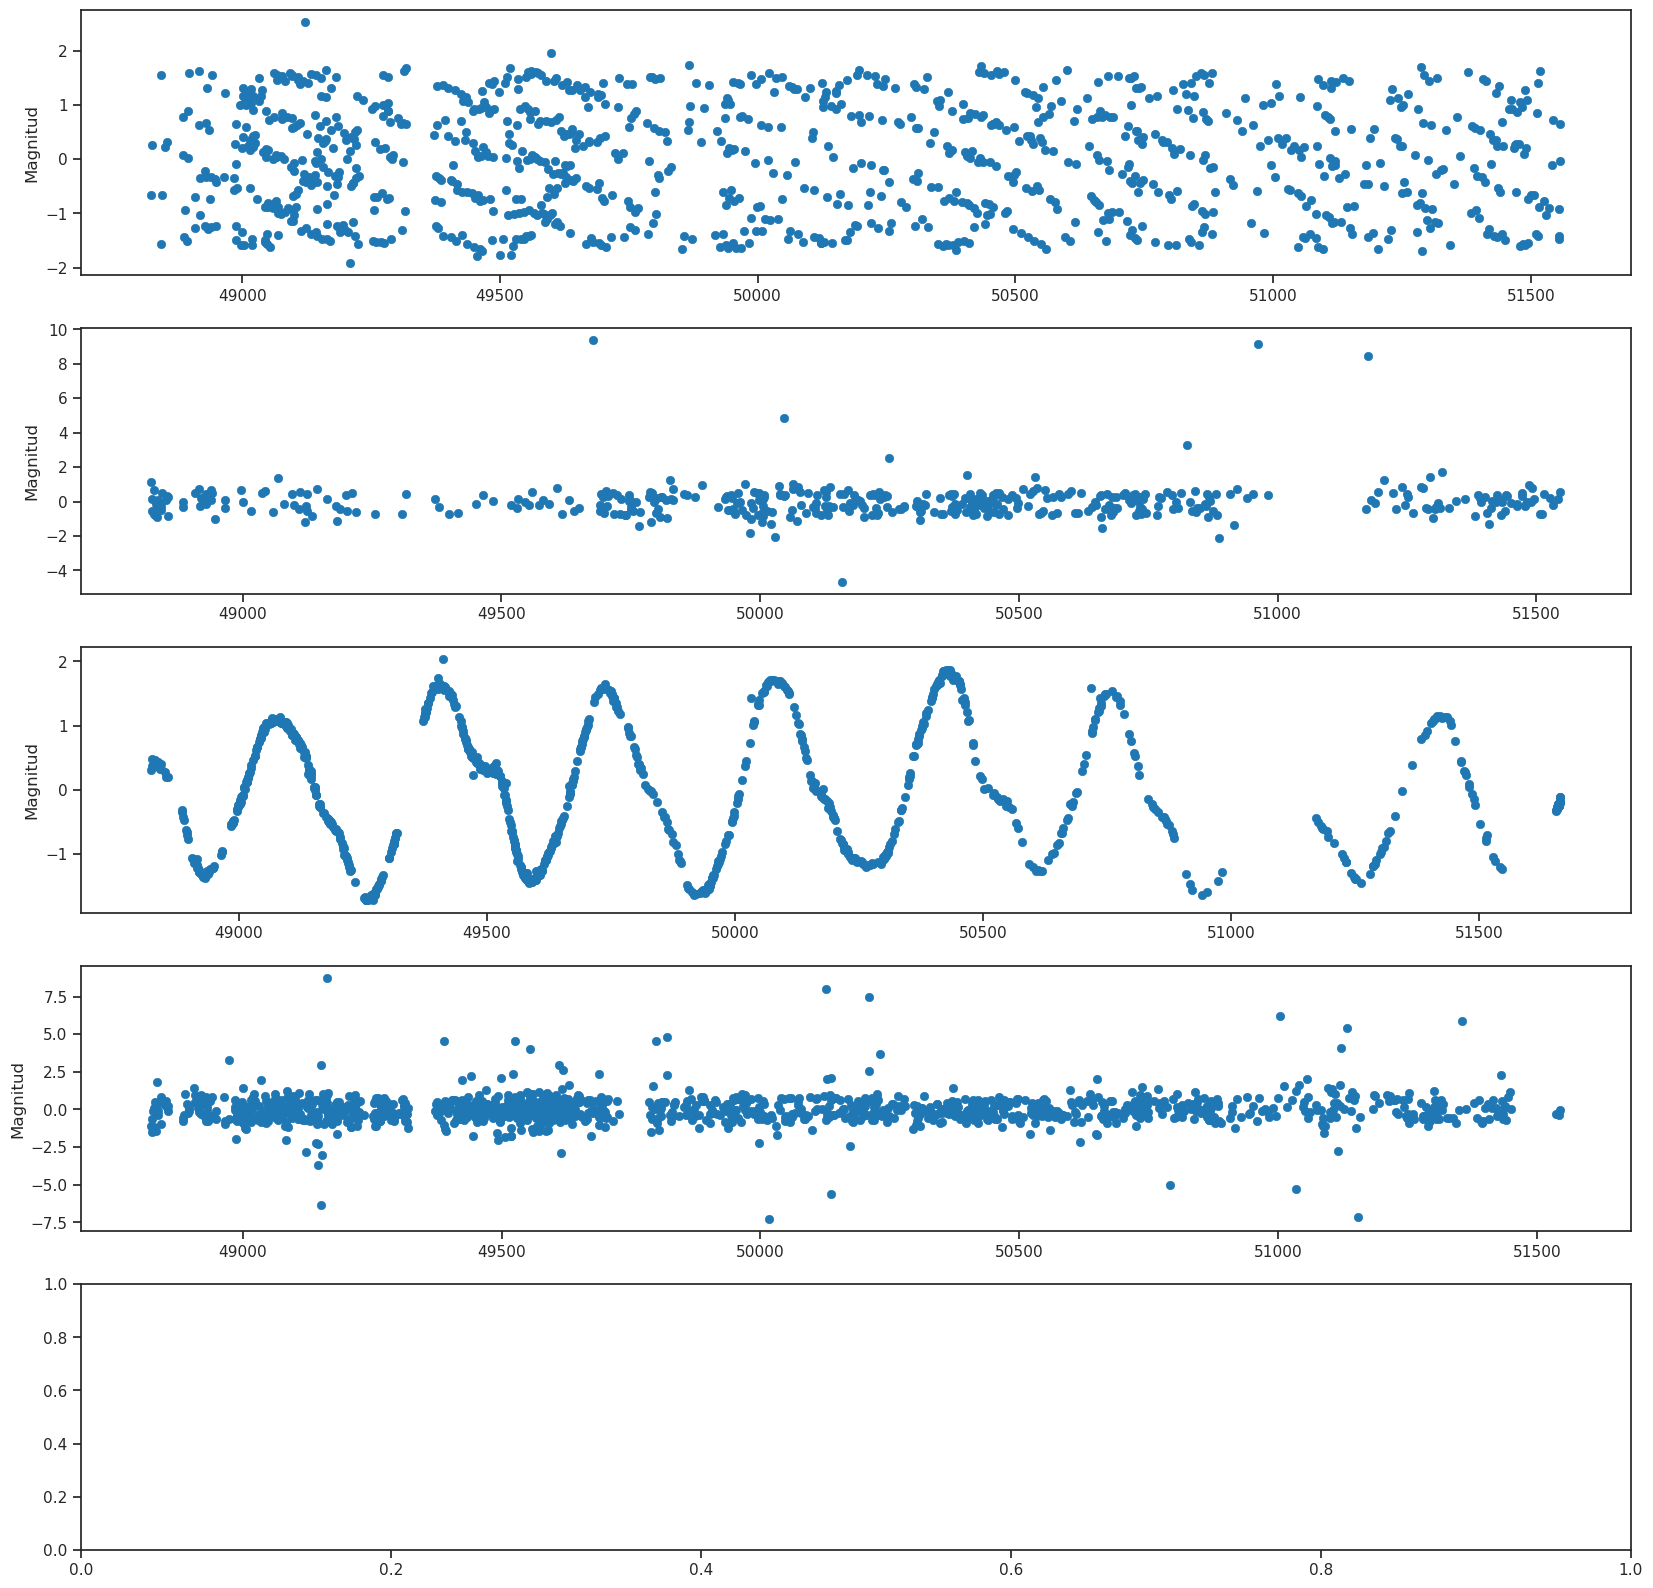

In [4]:
fig, ax = plt.subplots(5, figsize=(20,20))

for label in range(5):
    temp_data = train_data.to_df().loc[train_data.to_df()['label'] == label].iloc[0].copy()
    ax[label].scatter(temp_data.mjd, temp_data.mag, zorder=0.5,linewidth=0.5,alpha=1)
    ax[label].set_ylabel('Magnitud')
ax[0].set_title('Clase 1 - Señal "sinmix1" - P = [0.5, 2]')
ax[1].set_title('Clase 2 - Señal "sinmix2" - P = [5,10]')
ax[2].set_title('Clase 3 - Señal "sawtooth" - P = [1.5,4]')
ax[3].set_title('Clase 4 - Señal "square" - P = [2,8]')
ax[4].set_title('Clase 5 - Señal "gauss" - P = --')
plt.xlabel('Épocas')
plt.show()

### Clasificación

#### DataLoaders

In [6]:
batch_size = 128


train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            pin_memory=True,
                            num_workers=16,
                            shuffle=True)

val_loader = DataLoader(val_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16)                


#### Generación del modelo

In [7]:
dir_trained_models = get_project_root() / 'models' / 'trained_models'

In [8]:
n_classes = 3

checkpoint_callback = ModelCheckpoint(monitor="val_loss",
                                    dirpath=dir_trained_models,
                                    filename='model',
                                    save_top_k=1,
                                    mode='min')
loss_callback = MetricTracker()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0005)

In [9]:
n_seq_length = 60
n_embedding = 256
n_embedding_sub = 256
n_heads = 16
n_parallel_heads = n_embedding // n_heads   # parallel heads
n_classes = 4                              # num of classes
n_encoders = 2                              # stacked trasnformers encoders
n_out_channels = 64                        # global poolingg
kernel = 'loc-periodic'
batch_size = 64
kernel_size = 1  #

timeEncoder = TimeFilm(embedding_size=n_embedding, T_max=1500)

""" full model """
model = periodicTransformer(embedding_size=n_embedding, embedding_sub=n_embedding_sub, num_heads=n_heads, N=n_encoders,
                   TimeEncoder=timeEncoder, n_classes=n_classes
                   )

In [9]:
# model = periodicTransformer(n_classes=n_classes, d_model=256, d_ff=512, h=2, N=1)

In [10]:
trainer = pl.Trainer(accelerator='gpu',
                    callbacks=[early_stopping, checkpoint_callback, loss_callback],
                    max_epochs=-1,
                    check_val_every_n_epoch=10,
                    log_every_n_steps=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Training

In [11]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/agonzalez/projects/el7006/Projecto-EL7006/models/trained_models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | modulation     | TimeFilm   | 73.0 K
1 | encoders       | ModuleList | 790 K 
2 | classifier     | Sequential | 66.8 K
3 | val_acc        | Accuracy   | 0     
4 | test_f1        | F1Score    | 0     
5 | test_acc       | Accuracy   | 0     
6 | test_recall    | Recall     | 0     
7 | test_precision | Precision  | 0     
----------------------------------------------
930 K     Trainable params
7         Non-trainable params
930 K     Total params
3.721     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 160, in default_collate
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 160, in <dictcomp>
    return elem_type({key: default_collate([d[key] for d in batch]) for key in elem})
  File "/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 141, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [269] at entry 0 and [451] at entry 1


ValueError: x and y must have same first dimension, but have shapes (26,) and (25,)

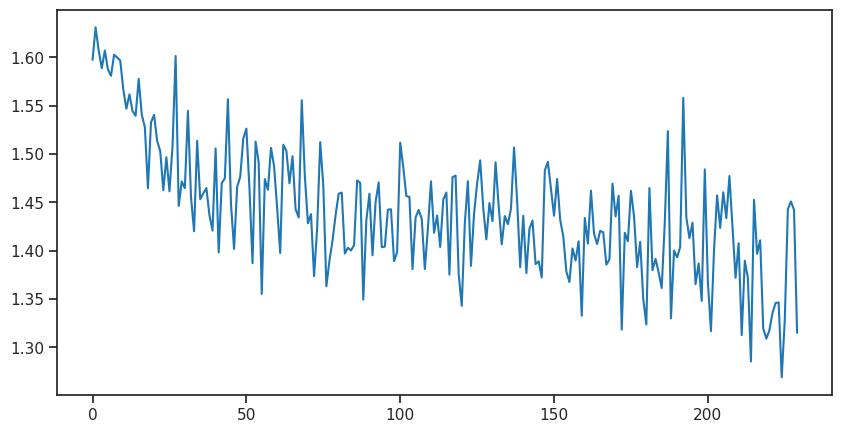

In [28]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(loss_callback.loss_history)
ax.plot(np.arange(0, len(loss_callback.loss_history)+1,9), loss_callback.val_loss_history)
ax.set_title('Loss history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train loss', 'Val loss'])
plt.show()

#### Testing

In [29]:
test_data = lc_dataset(seed=10)
test_data.add_curves('sinmix', N=100, seq_len=60, min_period=0.5, max_period=2, label=0)
test_data.add_curves('sinmix', N=100, seq_len=60, min_period=5, max_period=10, label=1)
test_data.add_curves('sawtooth', N=100, seq_len=60, min_period=1.5, max_period=4, label=2)
test_data.add_curves('square', N=100, seq_len=60, min_period=2, max_period=8, label=3)
test_data.add_curves('gauss', N=100, seq_len=60, min_period=2, max_period=8, label=4)

test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16,
                        shuffle=True)    

In [30]:
trainer.test(model, test_loader)
# _, test_predictions = trainer.test(model, test_loader)
# test_predictions = np.array(test_predictions)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/agonzalez/miniconda3/envs/el7006/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.30000001192092896
         test_f1            0.30000001192092896
        test_loss           1.5973303314079814
     test_precision         0.30000001192092896
       test_recall          0.30000001192092896
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5973303314079814,
  'test_acc': 0.30000001192092896,
  'test_recall': 0.30000001192092896,
  'test_precision': 0.30000001192092896,
  'test_f1': 0.30000001192092896}]

#### Matriz de confusión

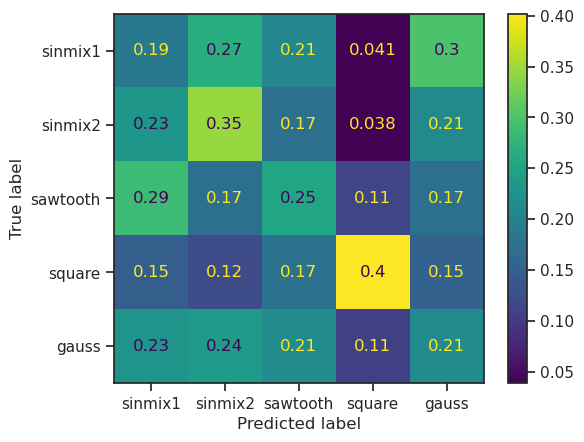

In [33]:
cm = confusion_matrix(
                    model.test_preds,
                    model.test_targ,
                    normalize='true')
disp = ConfusionMatrixDisplay(
                            confusion_matrix=cm,
                            display_labels=[
                                'sinmix1',
                                'sinmix2',
                                'sawtooth',
                                'square',
                                'gauss'])
disp.plot()
plt.show()

#### Otras métricas

In [35]:
print(
    classification_report(
        model.test_preds,
        model.test_targ,
        target_names=['sinmix1', 'sinmix2', 'sawtooth', 'square', 'gauss']
        )
        )

              precision    recall  f1-score   support

     sinmix1       0.18      0.19      0.18        97
     sinmix2       0.18      0.35      0.24        52
    sawtooth       0.22      0.25      0.24        87
      square       0.76      0.40      0.53       189
       gauss       0.16      0.21      0.18        75

    accuracy                           0.30       500
   macro avg       0.30      0.28      0.27       500
weighted avg       0.40      0.30      0.33       500



## Propuesta a futuro

- Datos con tiempos en distintos intervalos
- Datos con distintos rangos de magnitudes
- Analizar como afecta desbalance